# Yelp Reviews Classifier using NLP

Welcome to my NLP Project. This project will aim to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. 

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

In [150]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pundarikaksha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## The Data

In [151]:
yelp=pd.read_csv('data/yelp.csv')

In [3]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [152]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [153]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [154]:
yelp['text_length']=yelp['text'].apply(len)

# Exploratory Data Analysis

Let's explore the data


/Users/pundarikaksha/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


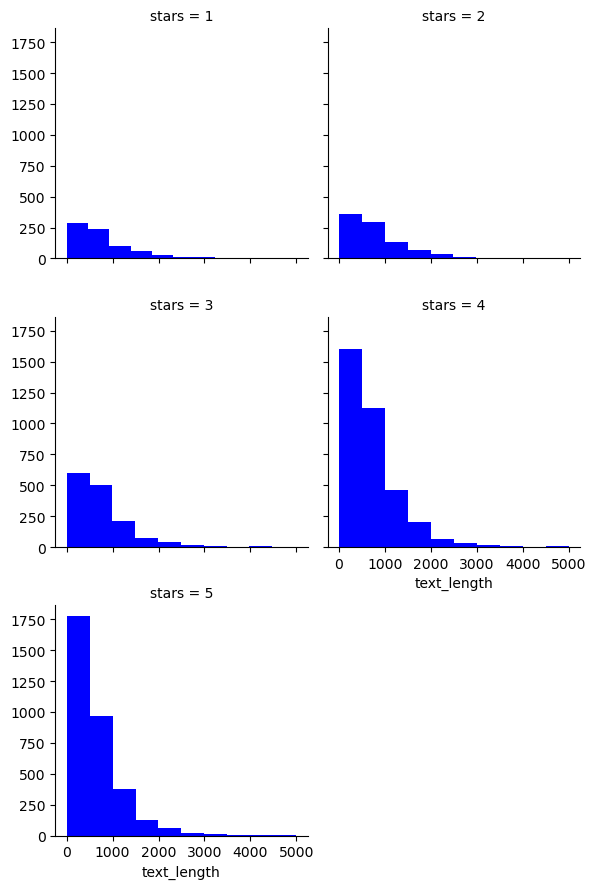

In [155]:
g = sns.FacetGrid(yelp, col="stars", col_wrap=2, height=3)

# Map a histogram to each subplot
g.map(plt.hist, 'text_length', bins=10, color='blue')

Hence we can see that people who write one star reviews tend to write in very less numbers. People who rate 4 stars and above tend to write a proper review, hence they have higher frequencies of writing.

<Axes: xlabel='stars', ylabel='text_length'>

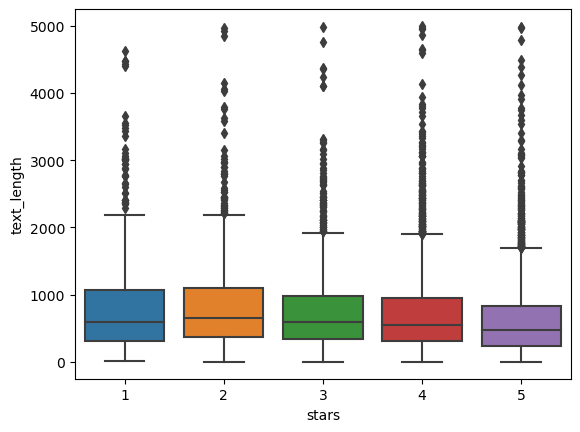

In [156]:
sns.boxplot(yelp,x="stars",y="text_length")

<Axes: xlabel='stars', ylabel='count'>

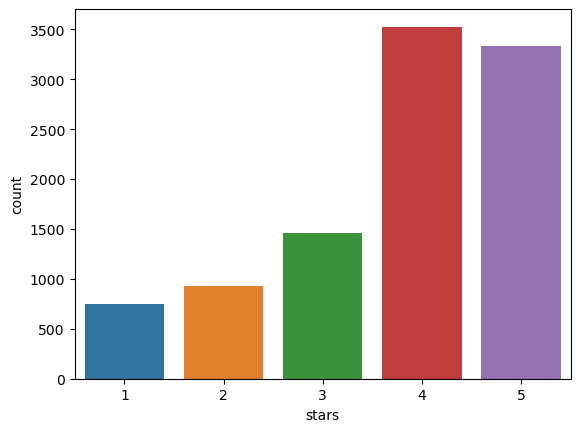

In [157]:
sns.countplot(yelp,x="stars")

Here we can see that people tend to give a review of 4 stars the most, followed by 5. People tend to give a 1 star review very less.

In [158]:
yelp.groupby("stars").describe()

cool                                                useful            \
        count      mean       std  min  25%  50%  75%   max   count      mean   
stars                                                                           
1       749.0  0.576769  1.474759  0.0  0.0  0.0  1.0  17.0   749.0  1.604806   
2       927.0  0.719525  1.491182  0.0  0.0  0.0  1.0  14.0   927.0  1.563107   
3      1461.0  0.788501  1.602576  0.0  0.0  0.0  1.0  18.0  1461.0  1.306639   
4      3526.0  0.954623  2.034367  0.0  0.0  0.0  1.0  38.0  3526.0  1.395916   
5      3337.0  0.944261  2.484583  0.0  0.0  0.0  1.0  77.0  3337.0  1.381780   

       ... funny       text_length                                       \
       ...   75%   max       count        mean         std   min    25%   
stars  ...                                                                
1      ...   1.0  30.0       749.0  826.515354  742.929304  11.0  315.0   
2      ...   1.0  20.0       927.0  842.256742  704.079491   7.0  365.5   
3      ...   1.0  24.0      1461.0  758.498289  627.594294   1.0  342.0   
4      ...   1.0  57.0      3526.0  712.923142  600.158476   2.0  307.0   
5      ...   1.0  39.0      3337.0  624.999101  558.578229   6.0  243.0   

                               
         50%      75%     max  
stars                          
1      600.0  1075.00  4618.0  
2      656.0  1105.00  4972.0  
3      599.0   975.00  4975.0  
4      551.5   945.75  4997.0  
5      471.0   826.00  4986.0  

[5 rows x 32 columns]

In [159]:
yelp.groupby("stars").describe().corr()

cool                                                \
                      count      mean       std min 25% 50% 75%       max   
cool        count  1.000000  0.943438  0.908819 NaN NaN NaN NaN  0.813511   
            mean   0.943438  1.000000  0.846576 NaN NaN NaN NaN  0.736045   
            std    0.908819  0.846576  1.000000 NaN NaN NaN NaN  0.981054   
            min         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            25%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            50%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            75%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            max    0.813511  0.736045  0.981054 NaN NaN NaN NaN  1.000000   
useful      count  1.000000  0.943438  0.908819 NaN NaN NaN NaN  0.813511   
            mean  -0.605269 -0.743329 -0.523378 NaN NaN NaN NaN -0.426161   
            std    0.601384  0.393575  0.814334 NaN NaN NaN NaN  0.884608   
            min         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            25%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            50%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            75%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            max    0.796660  0.714904  0.974533 NaN NaN NaN NaN  0.999328   
funny       count  1.000000  0.943438  0.908819 NaN NaN NaN NaN  0.813511   
            mean  -0.817300 -0.944939 -0.768596 NaN NaN NaN NaN -0.673136   
            std   -0.316562 -0.608641 -0.298713 NaN NaN NaN NaN -0.225455   
            min         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            25%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            50%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            75%         NaN       NaN       NaN NaN NaN NaN NaN       NaN   
            max    0.855597  0.685263  0.638814 NaN NaN NaN NaN  0.523122   
text_length count  1.000000  0.943438  0.908819 NaN NaN NaN NaN  0.813511   
            mean  -0.894531 -0.857664 -0.967043 NaN NaN NaN NaN -0.936775   
            std   -0.893572 -0.952652 -0.882630 NaN NaN NaN NaN -0.806413   
            min   -0.498224 -0.688376 -0.260007 NaN NaN NaN NaN -0.104331   
            25%   -0.719093 -0.545169 -0.893747 NaN NaN NaN NaN -0.935476   
            50%   -0.829063 -0.704984 -0.949357 NaN NaN NaN NaN -0.954903   
            75%   -0.856936 -0.829470 -0.939986 NaN NaN NaN NaN -0.914402   
            max    0.571414  0.807437  0.475004 NaN NaN NaN NaN  0.364203   

                     useful            ... funny           text_length  \
                      count      mean  ...   75%       max       count   
cool        count  1.000000 -0.605269  ...   NaN  0.855597    1.000000   
            mean   0.943438 -0.743329  ...   NaN  0.685263    0.943438   
            std    0.908819 -0.523378  ...   NaN  0.638814    0.908819   
            min         NaN       NaN  ...   NaN       NaN         NaN   
            25%         NaN       NaN  ...   NaN       NaN         NaN   
            50%         NaN       NaN  ...   NaN       NaN         NaN   
            75%         NaN       NaN  ...   NaN       NaN         NaN   
            max    0.813511 -0.426161  ...   NaN  0.523122    0.813511   
useful      count  1.000000 -0.605269  ...   NaN  0.855597    1.000000   
            mean  -0.605269  1.000000  ...   NaN -0.314044   -0.605269   
            std    0.601384 -0.089119  ...   NaN  0.488156    0.601384   
            min         NaN       NaN  ...   NaN       NaN         NaN   
            25%         NaN       NaN  ...   NaN       NaN         NaN   
            50%         NaN       NaN  ...   NaN       NaN         NaN   
            75%         NaN       NaN  ...   NaN       NaN         NaN   
            max    0.796660 -0.395030  ...   NaN  0.508019    0.796660   
funny       count  1.000000 -0.605269  ...   NaN  0.855597    1.000000  

## NLP Classification Task

Let's move on to the actual task. We will aim to just categorise reviews to 1 star (Very Poor) or 5 stars (Excellent).

In [160]:
yelp_class=yelp.loc[(yelp['stars']==1 ) | (yelp['stars']==5)]

In [161]:
X=yelp_class['text']
y=yelp_class['stars']

**Import CountVectorizer and create a CountVectorizer object.**

In [162]:
from sklearn.feature_extraction.text import CountVectorizer

In [163]:
X=CountVectorizer().fit_transform(X)

## Train Test Split

Let's split our data into training and testing data.


In [164]:
from sklearn.model_selection import train_test_split

In [165]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=101)

## Training a Model

Time to train a model!


In [166]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()

In [167]:
nb.fit(X_train,y_train)

MultinomialNB()

## Predictions and Evaluations

Time to see how our model did!


In [168]:
preds=nb.predict(X_test)

In [169]:
from sklearn.metrics import confusion_matrix,classification_report

In [170]:
print(confusion_matrix(y_test,preds))
print('\n')
print(classification_report(y_test,preds))

[[159  69]
 [ 22 976]]


              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



As we can see, the model performed pretty well even without text processing.

# Using Text Processing


In [171]:
#This function would remove any unnecessary words and punctuations from the sentences, for example "the,is" etc.
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [172]:
from sklearn.feature_extraction.text import TfidfTransformer

In [173]:
from sklearn.pipeline import Pipeline
pipeline=Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

## Using the Pipeline

**Time to use the pipeline!**

### Train Test Split


In [174]:
X=yelp_class['text']
y=yelp_class['stars']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=101)


**Now fit the pipeline to the training data.**

In [175]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x2846619e0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

### Predictions and Evaluation


In [176]:
predictions_with_tfidf=pipeline.predict(X_test)

In [177]:
print("Report of pipeline with TFIDF")
print('\n')
print(confusion_matrix(y_test,predictions_with_tfidf))
print('\n')
print(classification_report(y_test,predictions_with_tfidf))

Report of pipeline with TFIDF


[[  0 228]
 [  0 998]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



/Users/pundarikaksha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pundarikaksha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pundarikaksha/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looks like Tf-Idf actually made things worse! This can be due to two reasons:

**Imbalanced Class Distribution:**
Reviews with 1 star and 5 stars may have imbalanced distributions, meaning there might be significantly more reviews with one rating than the other. In such cases, the model may bias towards the majority class, making it challenging to accurately predict the minority class.

**Semantic Understanding**
TF-IDF focuses on the frequency of words but does not inherently capture the semantic meaning of words. Understanding sentiment often requires grasping the meaning of phrases and sentences, which might go beyond the capabilities of a simple TF-IDF model.